#Lab 5 - Machine Learning, Fall 2023
Collaborators: SJ Franklin, Nick Largey


# Gradient Descent Lab

*  We implement our very own gradient descent algorithm to solve the task of predict median house values in Californian districts, given a number of features from these districts.
* In this notebook, we strip out a lot of the data investigation work. In addition, we only consider a small subset of the columns
* Read/run through the notebook and fund the exercises at the end


# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np

import os
import tarfile
import urllib.request

import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error


# Get the Data
   
   But first, few constant and f()s

In [2]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Download the Data

In [3]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
fetch_housing_data()

In [5]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [6]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


## Create a Test Set

In [7]:
# to make this notebook's output identical at every run
np.random.seed(42)

In [8]:
import numpy as np

# For illustration only. Sklearn has train_test_split()
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [9]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [10]:
len(test_set)

4128

# Prepare the Data for Machine Learning Algorithms

## Data Cleaning ... minimal

In [11]:
housing_cols = ['housing_median_age', 'total_rooms', 'population', 'median_income']
housing_num = housing[housing_cols].fillna(housing[housing_cols].median())
housing_labels = housing['median_house_value']

## Transformation Pipelines

Now let's build a pipeline for preprocessing the numerical attributes:

In [12]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [13]:
housing_num_tr

array([[ 0.98214266, -0.8048191 , -0.9744286 ,  2.34476576],
       [-0.60701891,  2.0458901 ,  0.86143887,  2.33223796],
       [ 1.85618152, -0.53574589, -0.82077735,  1.7826994 ],
       ...,
       [-0.92485123, -0.17499526, -0.3695372 , -1.14259331],
       [-0.84539315, -0.35559977, -0.60442933, -1.05458292],
       [-1.00430931,  0.06840827, -0.03397701, -0.78012947]])

# Select and Train a Model

## Easy way : Training and Evaluating on the Training Set

In [14]:
sgd_reg = SGDRegressor(max_iter=10000, eta0=1e-3, tol=1e-3, random_state=42)
sgd_reg.fit(housing_num_tr, housing_labels)

SGDRegressor(eta0=0.001, max_iter=10000, random_state=42)

In [15]:
housing_predictions = sgd_reg.predict(housing_num_tr)
sgd_mse = mean_squared_error(housing_labels, housing_predictions)
sgd_rmse = np.sqrt(sgd_mse)
sgd_rmse

80211.74173521325

In [16]:
print(" theta values from SGD",sgd_reg.coef_)
print(" y intercept ", sgd_reg.intercept_)

 theta values from SGD [ 24889.63064788  20050.99333882 -12983.02624215  78419.00064077]
 y intercept  [206839.75946179]


In [17]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_num_tr, housing_labels)

LinearRegression()

In [18]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_num_tr)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

80211.61384149214

In [54]:
print(" theta values from Linear regression",lin_reg.coef_)
print(" y intercept ", lin_reg.intercept_)

 theta values from Linear regression [ 24935.89490518  20319.34402469 -13252.56472763  78406.98656563]
 y intercept  206855.81690891474


## Manual SGD : Training and Evaluating on the Training Set

Sci-kit learn SGD and linear regression add a term for the y-intercept automatically, but we have to do it ourselves for the manual solution

In [65]:
housing_num_tr_b = np.c_[np.ones((housing_num_tr.shape[0], 1)), housing_num_tr] # add x0 = 1 to each instance
print(housing_num_tr_b.shape)
print(housing_num_tr.shape)

(20640, 5)
(20640, 4)


### Exercise : Cost Function

Implement the Mean squared error cost function for a linear regression (Pg 114 of the book).
As a challenge, I encourage you to form the matrix/vector form of the equation. For loop is okay though

In [66]:
# Can also use np.sum
# Define computeCost function
def computeCost(X, y, theta):
  sum = 0
  for i, x in enumerate(X):
    sum += ((theta.T.dot(x) - y[i])) ** 2
  return (sum / X.shape[0])

computeCost(housing_num_tr, housing_labels, sgd_reg.coef_)

49223252243.4094

We test out our cost function for specific theta values

In [22]:
# Calculate computeCost with theta equal to zeros
theta = np.zeros(housing_num_tr_b.shape[1])

J1 = computeCost(housing_num_tr_b, housing_labels, theta)
print("With theta = %s, \nCost computed = %.2f " % (theta, J1))

#Answer Should be :
#    With theta = [0. 0. 0. 0. 0.],
#    Cost computed = 56104831989



With theta = [0. 0. 0. 0. 0.], 
Cost computed = 56104831989.87 


### Exercise : Batch Gradient Descent

Implement the batch gradient descent algorithm, save the cost at every iteration and return it along with
the improved theta value

In [43]:
pip install tqdm

In [75]:
#  Define the gradient descent algorithm and return cost history and theta
from tqdm import tqdm

def gradientDescent(X, y, theta, iterations, eta):
    J_hist = np.zeros([iterations])
    gradient = np.zeros([X.shape[1]])
    # Manually calculate each partial derivative (the gradient) of the cost function
    for j in range(gradient.shape[0]):
      sum = 0
      for i, x in enumerate(X):
        sum += ((theta.T.dot(x) - y[i])) * (x[j])

      gradient[j] = (2 / X.shape[0]) * sum

    # Set progress bar
    progress_bar = tqdm(total=iterations, desc="Gradient Descent Progress")

    # # Calculate the gradient descent at each step (takes 9 minutes)
    # for iteration in range(iterations):
    #   theta = theta - eta * gradient
    #   J_hist[iteration] = computeCost(X, y, theta) # Save cost at each step
    #   progress_bar.update(1) # Update progress bar

    # Calculate the gradient descent at each step (fast version)
    for iteration in range(iterations):
      error = X.dot(theta) - y            # predicted value, subtracted from the label
      gradients = (2/(X.shape[0])) * X.T.dot(error)
      theta = theta - eta * gradients
      J_hist[iteration] = np.mean(error ** 2)
      progress_bar.update(1) # Update progress bar

    # Close the progress bar when done
    progress_bar.close()

    return theta, J_hist

Now run the batch gradient descent algorithm and check against my results

In [73]:
theta, J_hist = gradientDescent(housing_num_tr_b, housing_labels, theta, iterations=5000,eta=1e-3)
J1 = computeCost(housing_num_tr_b, housing_labels, theta)
print("With theta = %s, \nCost computed = %.2f " % (theta, J1))


Gradient Descent Progress: 100%|██████████| 5000/5000 [00:07<00:00, 634.95it/s]


With theta = [206855.81690892  24935.97880726  20320.71033762 -13253.86553799
  78406.69759784], 
Cost computed = 6433902995.49 


In [45]:
theta, J_hist = gradientDescent(housing_num_tr_b, housing_labels, theta, iterations=5000,eta=1e-3)
J1 = computeCost(housing_num_tr_b, housing_labels, theta)
print("With theta = %s, \nCost computed = %.2f " % (theta, J1))

# With theta initialized to zero, I get 3221295137.061254 for the cost

Gradient Descent Progress: 100%|██████████| 5000/5000 [09:04<00:00,  9.19it/s]


With theta = [206855.81690905  24936.81809621  20334.37783283 -13266.8777982
  78403.80699654], 
Cost computed = 6433903048.03 


In [76]:
print(" theta values from Manual BGD",theta[1:4])
print(" y intercept ", theta[0])

 theta values from Manual BGD [ 24935.97880726  20320.71033762 -13253.86553799]
 y intercept  206855.81690892196


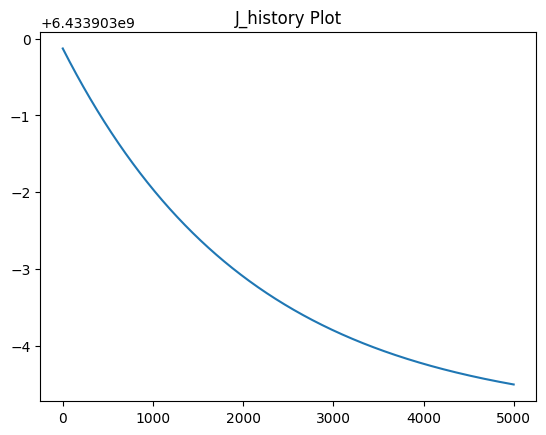

In [77]:
# Lets look at how the cost changes through iterations
plt.title("J_history Plot")
plt.plot(J_hist)

### Exercise : Compute the root mean squared error

Compare results to linear regression and Stochastic gradient descent. Why do you think the results are not quite as good as the scikit learn results ? (May want to look

I get 80265.74782634563 with theta initialized to zero, iterations=5000,eta=1e-3

# Answer:

I think we must've messed something up somewhere. The cost function value wasn't getting anywhere close to the example cost (3221295137.061254), and the RMSE values have all been similar to the Linear and SGD scikit models...

Tried lowering the hyperparameters, but getting very similar results, which tells us that something has DEFINITELY gone wrong. This feels like an early sign of overfitting the training data.

Put in a few hours making modifications to the manual BDG. Some of the attempts were running for several minutes (added in progress bars, because we were worried that things might have been going on infinite loops, and wanted to make sure it wasn't waiting for nothing). Stopping here since we think the expectation was to not spend as much time on the lab as has been spent.

In [85]:
bgd_rmse = np.sqrt(J1)
bgd_rmse

80211.61384248229

In [79]:
print(" theta values from SGD",sgd_reg.coef_)
print(" y intercept ", sgd_reg.intercept_)
print(sgd_rmse)

print("\n\n theta values from Linear regression",lin_reg.coef_)
print(" y intercept ", lin_reg.intercept_)
print(lin_rmse)

print("\n\n theta values from Manual BGD",theta[1:4])
print(" y intercept ", theta[0])
print(bgd_rmse)

 theta values from SGD [ 24889.63064788  20050.99333882 -12983.02624215  78419.00064077]
 y intercept  [206839.75946179]
80211.74173521325


 theta values from Linear regression [ 24935.89490518  20319.34402469 -13252.56472763  78406.98656563]
 y intercept  206855.81690891474
80211.61384149214


 theta values from Manual BGD [ 24935.97880726  20320.71033762 -13253.86553799]
 y intercept  206855.81690892196
80211.61384421986


### Exercise : Hyperparameters

Change some of the hyperparameters (iterations or eta) to get an improved root mean squared (I was able to match scki-kit learn results of 80211)

In [84]:
theta, J_hist = gradientDescent(housing_num_tr_b, housing_labels, theta, iterations=1,eta=1e-1)
J1 = computeCost(housing_num_tr_b, housing_labels, theta)
print("With theta = %s, \nCost computed = %.2f " % (theta, J1))
bgd_rmse = np.sqrt(J1)
bgd_rmse


Gradient Descent Progress: 100%|██████████| 1/1 [00:00<00:00, 189.00it/s]


With theta = [206855.81690892  24935.94546231  20320.16732809 -13253.34856095
  78406.81244141], 
Cost computed = 6433902995.22 


80211.61384248229

### Graduate students, Extra credit

Implement Stochastic gradient descent and compare the performance to batch gradient descent. Explain the results

In [86]:
# learning schedule hyperparameters
t0, t1 = 5, 50

def learning_schedule(t):
  return t0 / (t + t1)

#  Define the gradient descent algorithm and return theta
from tqdm import tqdm

def stochGradientDescent(X, y, theta, epochs, eta):
    m = X.shape[0]

    # Set progress bar
    progress_bar = tqdm(total=epochs, desc="Gradient Descent Progress")

    for epoch in range(epochs):
      for i in range(m):
        random_index = np.random.randint(m)
        xi = X[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

      progress_bar.update(1) # Update progress bar

    # Close the progress bar when done
    progress_bar.close()

    return theta

In [87]:
theta = stochGradientDescent(housing_num_tr_b, housing_labels, theta, epochs=10,eta=1e-3)
J1 = computeCost(housing_num_tr_b, housing_labels, theta)
print("\nWith theta = %s, \nCost computed = %.2f " % (theta, J1))
bgd_rmse = np.sqrt(J1)
bgd_rmse


Gradient Descent Progress: 100%|██████████| 10/10 [00:59<00:00,  5.99s/it]

With theta = [207281.95875258  24650.71516967  20075.45507954 -13125.03603814
  78669.22027272], 
Cost computed = 6434221202.10 


80213.59736419316